In [24]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from rfpimp import oob_regression_r2_score

# 0. set parameters
fts = 10  # features shown in plot
thr = 0.05

In [25]:
# 1. get data
'''
agg_data = pd.read_csv('data_include_all_features.csv')
agg_data = agg_data.drop(columns=['V1', 'year', 'quarter', 'GEOID', 'lat', 'lng', 'NAME'])
X_train, X_test, y_train, y_test = train_test_split(agg_data.drop(columns='N'), agg_data['N'], test_size=0.2)
'''
agg_data = pd.read_csv("crime_data\\crime_assualt_data_yearly.csv", index_col=0)
agg_data = agg_data.drop(columns=['year', 'GEOID'])
X_train, X_test, y_train, y_test = train_test_split(agg_data.drop(columns='crime'), agg_data['crime'], test_size=0.2)

X_train[np.isnan(X_train)] = 0  # robbery documented as NA when it's zero
X_test[np.isnan(X_test)] = 0
X_train['random'] = np.random.random(size=len(X_train))  # add a column of random numbers
X_test['random'] = np.random.random(size=len(X_test))

rf = RandomForestRegressor(
         n_estimators=100,
         min_samples_leaf=1,
         n_jobs=-1,
         oob_score=True)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

Feature ranking:
1. feature 67 : Income_in_the_past_12_months_below_poverty_level_Male (0.198517)
2. feature 71 : Income_in_the_past_12_months_below_poverty_level_Male_Not_in_labor_force (0.124795)
3. feature 159 : prop_male (0.081655)
4. feature 141 : With_income_10000_to_14999 (0.071704)
5. feature 123 : Moved_within_same_county_Male (0.041459)
6. feature 127 : Not_Hispanic_or_Latino_Black_or_African_American_alone (0.031654)
7. feature 162 : prop_under_poverty_level (0.025677)
8. feature 171 : mta_stops (0.022564)
9. feature 161 : prop_hispanic (0.019151)
10. feature 135 : Renter_occupied (0.017438)

Random feature importance: 0.000368


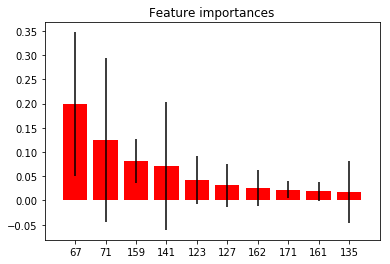

In [26]:
# 2. plot feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:fts]

# Print the feature ranking
print("Feature ranking:")

for f in range(fts):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X_train.columns.values[indices[f]], importances[indices[f]]))
print("\nRandom feature importance: %f" % importances[-1])
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(fts), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(fts), indices)
plt.xlim([-1, fts])
plt.show()

In [27]:
# 3 feature selection
sel = SelectFromModel(RandomForestRegressor(n_estimators=100), threshold=thr)
sel.fit(X_train, y_train)

selected_feat = X_train.columns[(sel.get_support())]
n_features = len(selected_feat)
print(selected_feat)

Index(['Income_in_the_past_12_months_below_poverty_level_Male',
       'Income_in_the_past_12_months_below_poverty_level_Male_Not_in_labor_force',
       'With_income_10000_to_14999', 'prop_male'],
      dtype='object')


Feature ranking:
1. feature 67 : Income_in_the_past_12_months_below_poverty_level_Male (0.185169)
2. feature 159 : prop_male (0.181491)
3. feature 71 : Income_in_the_past_12_months_below_poverty_level_Male_Not_in_labor_force (0.047717)
4. feature 123 : Moved_within_same_county_Male (0.039107)
5. feature 171 : mta_stops (0.035764)
6. feature 162 : prop_under_poverty_level (0.029694)
7. feature 127 : Not_Hispanic_or_Latino_Black_or_African_American_alone (0.027582)
8. feature 141 : With_income_10000_to_14999 (0.025476)
9. feature 161 : prop_hispanic (0.022852)
10. feature 163 : prop_rented_to_owned (0.020959)

Random feature importance: -0.000256


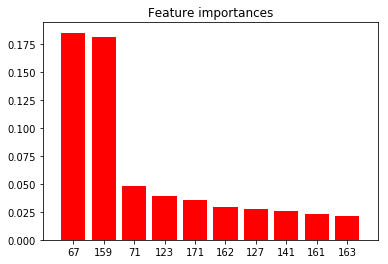

In [28]:
# 4: other importance
# 4.1 permutation importance
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

importances = permutation_importances(rf, X_train, y_train, oob_regression_r2_score)
indices = np.argsort(importances)[::-1][:fts]

# Print the feature ranking
print("Feature ranking:")

for f in range(fts):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X_train.columns.values[indices[f]], importances[indices[f]]))
print("\nRandom feature importance: %f" % importances[-1])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(fts), importances[indices],
       color="r", align="center")
plt.xticks(range(fts), indices)
plt.xlim([-1, fts])
plt.show()

Feature ranking:
1. prop_male (0.015814)
2. racial_index (0.003560)
3. Same_house_1_year_ago (0.003261)
4. mta_stops (0.003113)
5. Female_10th_grade (0.002943)
6. Moved_from_different_county_within_same_state_Female (0.002345)
7. Income_in_the_past_12_months_below_poverty_level_Male_In_labor_force (0.001702)
8. water (0.001653)
9. Male_50_to_54_years (0.000950)
10. less_hs (0.000764)

Random feature importance: -0.003618


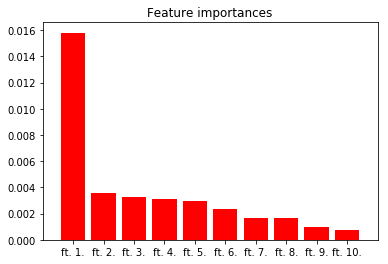

In [29]:
# 4.2 drop-column importance
def dropcol_importances(rf, X_train, y_train):
    rf_ = copy.deepcopy(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = copy.deepcopy(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

importances = dropcol_importances(rf, X_train, y_train)

# Print the feature ranking
print("Feature ranking:")

for f in range(fts):
    print("%d. %s (%f)" % (f + 1, importances.index.values[f], importances.iloc[f, 0]))
print("\nRandom feature importance: %f" % importances.loc['random', 'Importance'])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(fts), importances.iloc[0:fts, 0],
       color="r", align="center")
plt.xticks(range(fts), ["ft. %d." % (f + 1) for f in range(fts)])
plt.xlim([-1, fts])
plt.show()